In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import salem
import xarray as xr
# Some defaults
cmap = plt.get_cmap('RdBu_r')
import ipdb
from utils import constants as cnst, u_darrays as uda
import shapely.geometry as shpg
from scipy.stats import gaussian_kde, linregress

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
chirps = '/media/ck/Elements/SouthAmerica/CHIRPS/chirps-v2.0.daily.peru.nc'

fpath = cnst.network_data + 'figs/HUARAZ/'

fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
isbuffer = [-79, -74, -12, -6]

sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)

ca = xr.open_dataarray(chirps).sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3])).salem.roi(shape=sdf)
# Rio Santa basin only


In [4]:
def readERA(file):

    u200orig = xr.open_dataarray(file)
    #u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/v850_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [5]:
u200 = readERA('/media/ck/Elements/SouthAmerica/ERA5/hourly/u200_15UTC_1981-2019_peru_big.nc')
isvalley = [-78.3,-76.8,-10.7,-8]
isjet = [-75.5,-74.5,-8.5,-6.5]
u200 = u200.sel(longitude=slice(isvalley[0], isvalley[1]), latitude=slice(isvalley[2], isvalley[3])).mean(['latitude', 'longitude'])
v850 = readERA('/media/ck/Elements/SouthAmerica/ERA5/hourly/v850_15UTC_1981-2019_peru_big.nc')
v850 = v850.sel(longitude=slice(isjet[0], isjet[1]), latitude=slice(isjet[2], isjet[3])).mean(['latitude', 'longitude'])

ValueError: dimensions or multi-index levels ['longitude', 'latitude'] do not exist

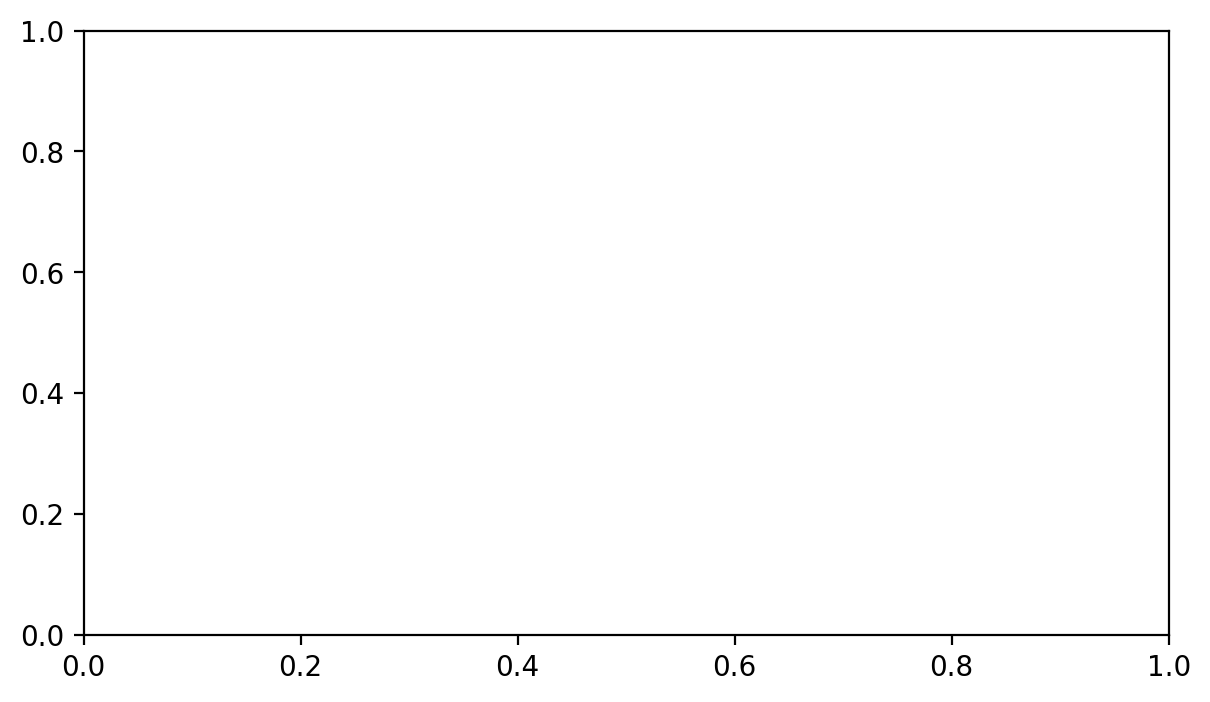

In [6]:
map = ca.salem.get_map()
f = plt.figure(figsize=(7,4), dpi=200)

ax = f.add_subplot(111)

map.set_data(v850.sel(longitude=slice(isjet[0], isjet[1]), latitude=slice(isjet[2], isjet[3]))[2000,:,:])
coord = isjet
geom = shpg.box(coord[0], coord[2], coord[1], coord[3])
map.set_geometry(geom, zorder=99, color='darkorange', linewidth=3, linestyle='--', alpha=0.1)
map.visualize()

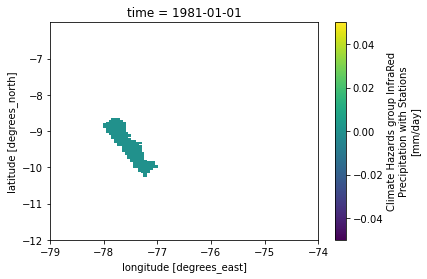

In [7]:
ca[0,:,:].plot()

In [8]:
ca_rainy = ca.mean(['latitude', 'longitude'])
#ca_rainy = ca_rainy.where(ca_rainy>0.1, drop=True)

In [11]:
u200roll = u200.rolling(time=3, min_periods=1, center=True).mean(dim='time') # time=3
v850roll = v850.rolling(time=3, min_periods=1, center=True).mean(dim='time')
chroll = ca_rainy.rolling(time=3, min_periods=1, center=True).mean(dim='time') # time=3

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Reductions will be applied along the rolling dimension '['time']'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  """Entry point for launching an IPython kernel.
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Reductions will be applied along the rolling dimension '['time']'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Reductions will be applied along the rolling dimension '['time']'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
np.unique(ca_rainy['time.year'])

array([1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019])

In [13]:
ca_rainy

<xarray.DataArray 'precip' (time: 13999)>
array([0.        , 0.        , 0.16201863, ..., 2.6219342 , 1.8869944 ,
       0.6755347 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2019-04-30

In [15]:
posgrid200 = np.intersect1d(u200roll.time.values, chroll.time.values)
posgrid850 = np.intersect1d(v850roll.time.values, chroll.time.values)

u200ca = u200roll.sel(time=posgrid200)
v850ca = v850roll.sel(time=posgrid850)

cau200 = chroll.sel(time=posgrid200)
cav850 = chroll.sel(time=posgrid850)

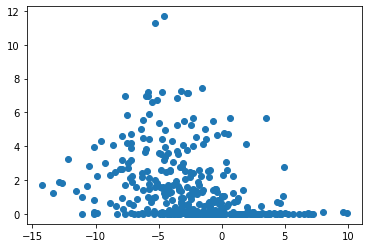

In [17]:
y=1990
plt.scatter(v850ca[v850ca['time.year']==y], cav850[cav850['time.year']==y])

In [61]:
u200.shape

(14610,)

In [62]:
v850.shape

(14610,)

In [63]:
posgrid200 = np.intersect1d(u200.time.values, ca_rainy.time.values)
posgrid850 = np.intersect1d(v850.time.values, ca_rainy.time.values)

u200ca = u200.sel(time=posgrid200)
v850ca = v850.sel(time=posgrid850)

cau200 = ca_rainy.sel(time=posgrid200)
cav850 = ca_rainy.sel(time=posgrid850)

In [64]:
np.all(cau200.time==cav850.time)

<xarray.DataArray 'time' ()>
array(True)

In [65]:
np.all(u200ca.time==v850ca.time)

<xarray.DataArray 'time' ()>
array(True)

In [66]:
def perc_1d_binning(data, xvar, xbins):
    import warnings
    """
    :param xvar: xvar of the 2dhist
    :param yvar: yvar of the 2d hist
    :param xbins: bins to use for the xvar
    :param ybins: bins to use for the yvar
    :param varlist: dictionary of variables to put into histogram
    :param varpick: list of variables in dic to calculate
    :return:
    """
    outdic = {}
    outdic['data'] = []


    for issh, shl in enumerate(xbins[0:-1]):

        poss_ds = (xvar > shl) & (xvar <= xbins[issh + 1])
        valdat = (data[poss_ds])[np.isfinite(data[poss_ds])]
        #dat = np.percentile(valdat, perc)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            dat = np.nanmean(valdat)

        outdic['data'].append(dat)

        #ipdb.set_trace()

    outdic['xbins'] = (np.round(xbins[0:-1]+((xbins[1::]-xbins[0:-1])/2),2))


    return outdic

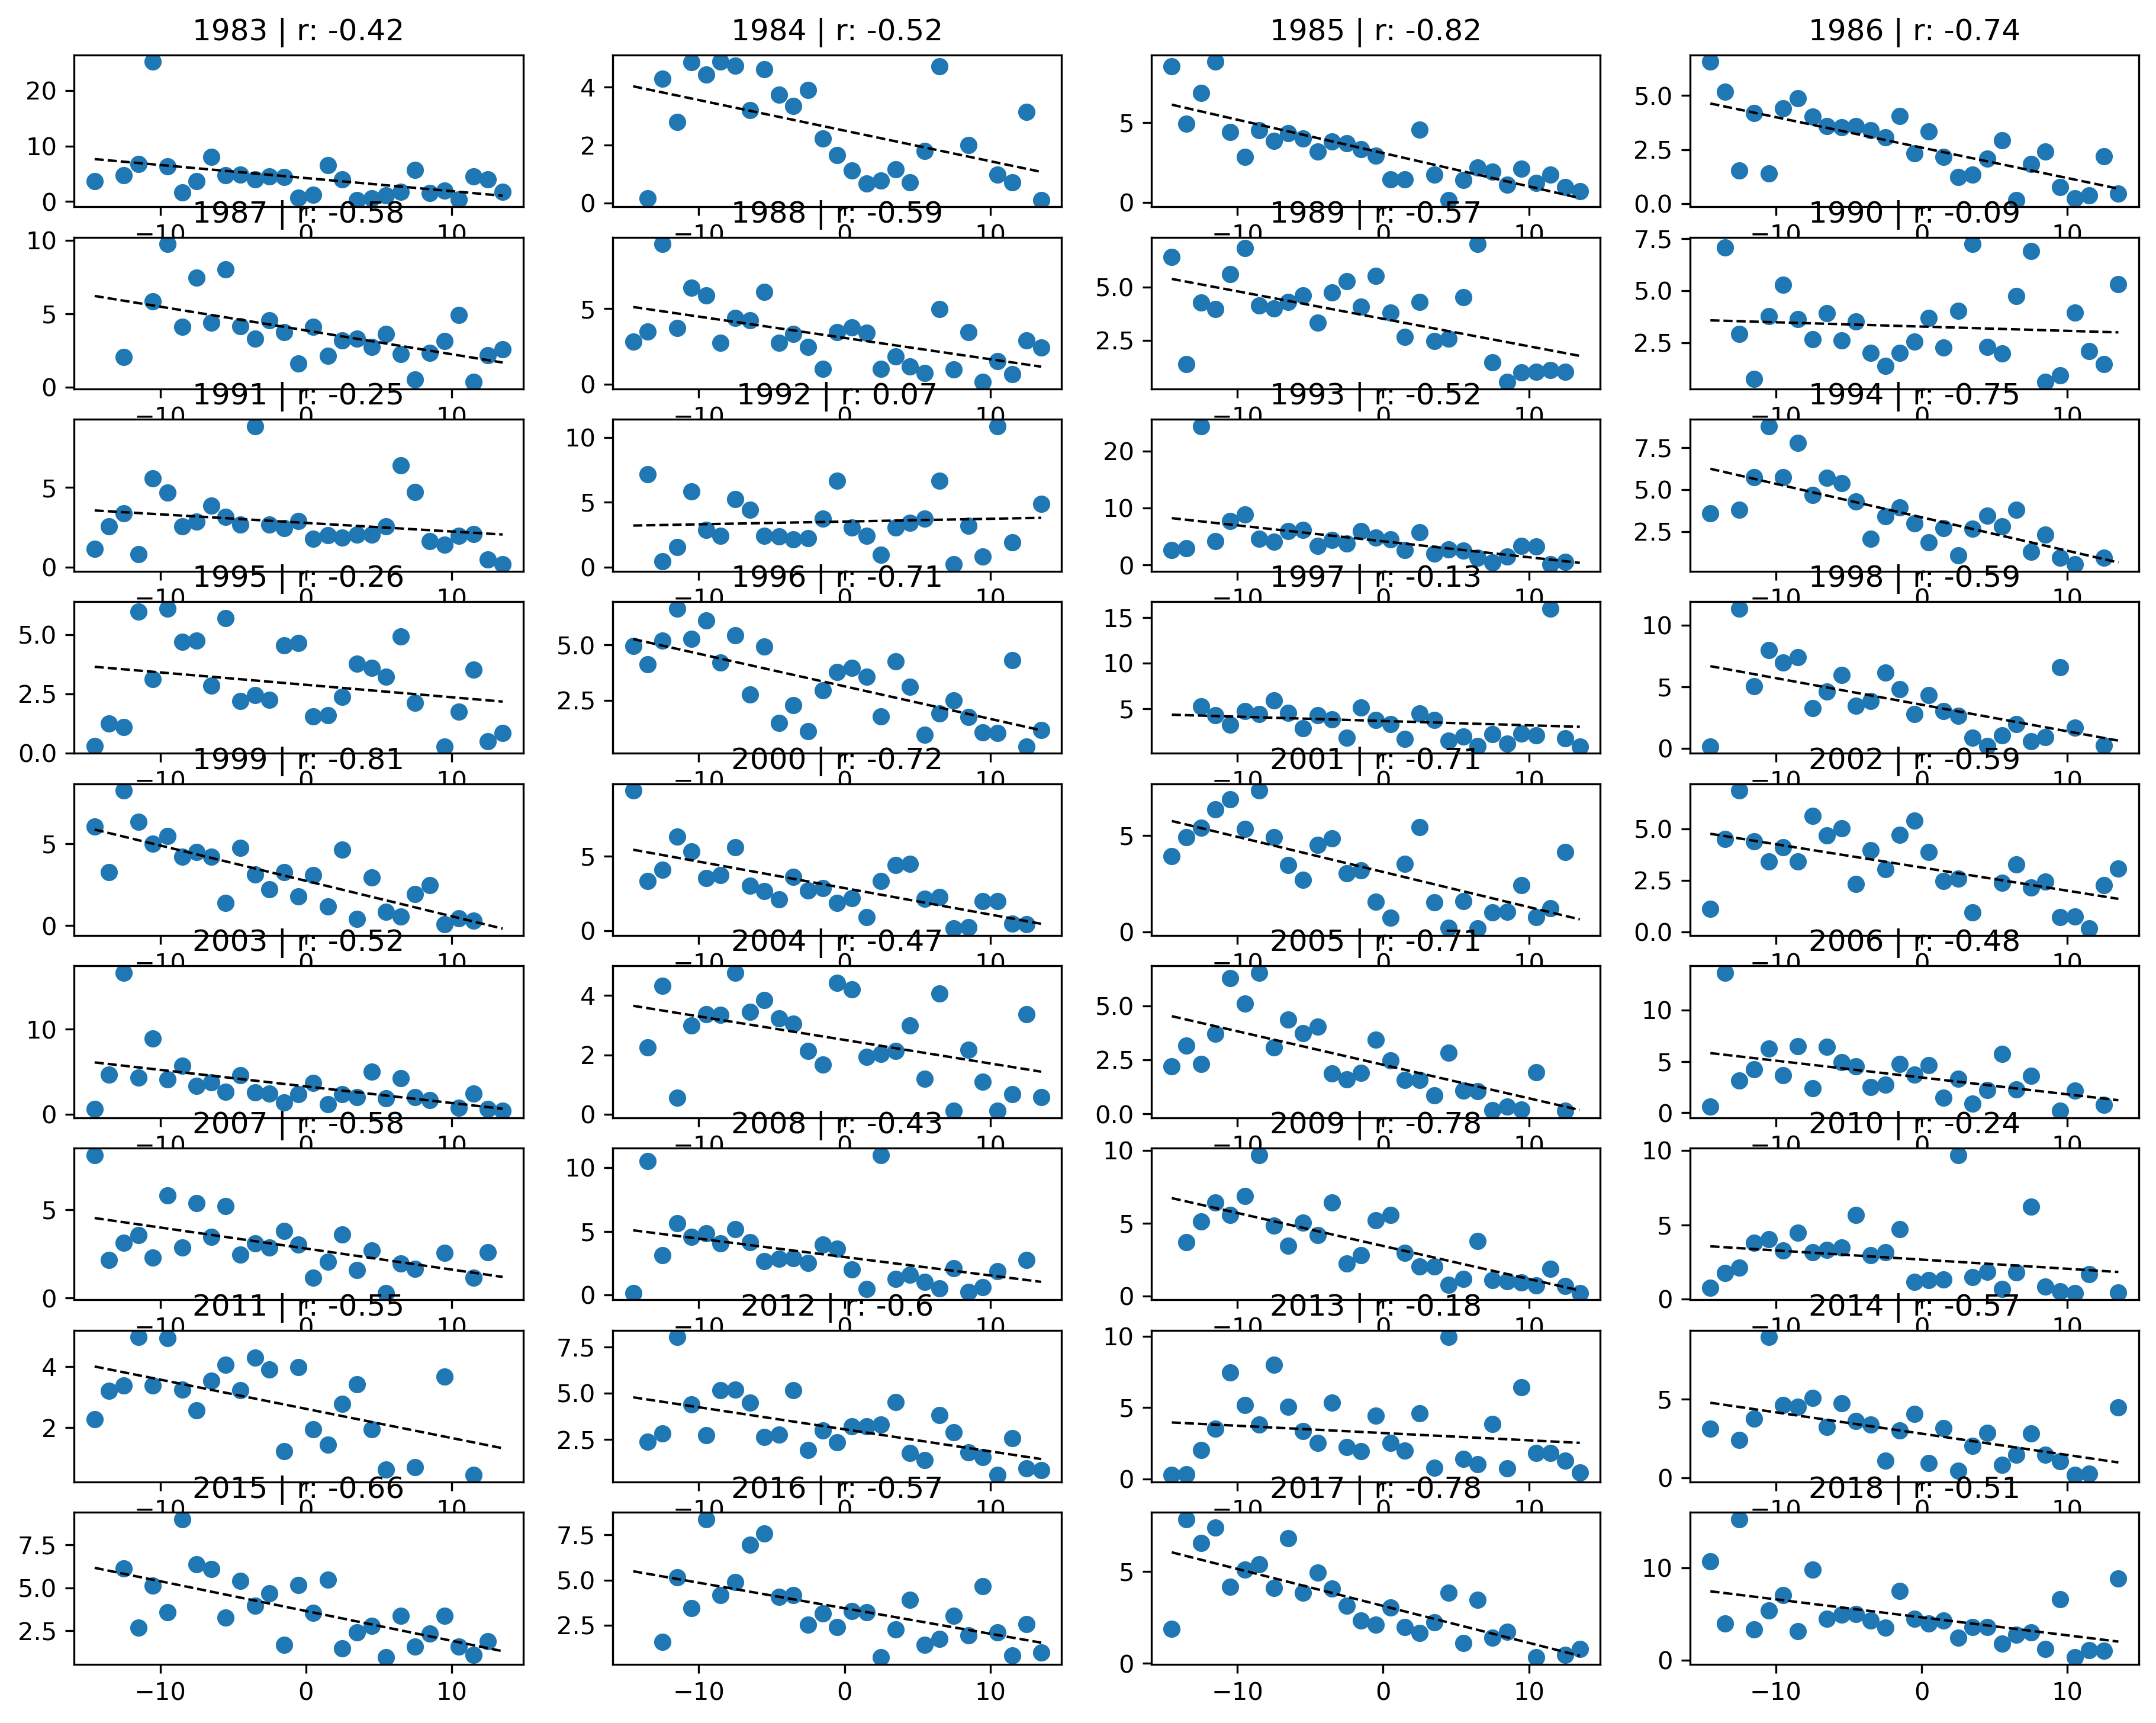

In [74]:
f = plt.figure(figsize=(15,12), dpi=300)
u200_stats = {'corr': [], 'pval' : [], 'slope' : []}

for ids,y in enumerate(range(1983,2019)):
    cadic = perc_1d_binning(cau200[cau200['time.year']==y], u200ca[u200ca['time.year']==y], xbins=np.arange(-15,15,1))
    isval = np.isfinite(cadic['data'])
    b, a, r_value, p_value, std_err = linregress(np.array(cadic['xbins'])[isval],np.array(cadic['data'])[isval])

    ax = f.add_subplot(9,4,ids+1)
    ax.scatter(cadic['xbins'], cadic['data'])
    ax.plot(cadic['xbins'], a+cadic['xbins']*b, color='k', linestyle='dashed', linewidth=1)
    plt.title(str(y)+' | r: '+str(np.round(r_value,2)))
    u200_stats['corr'].append(r_value)
    u200_stats['pval'].append(p_value)
    u200_stats['slope'].append(b)

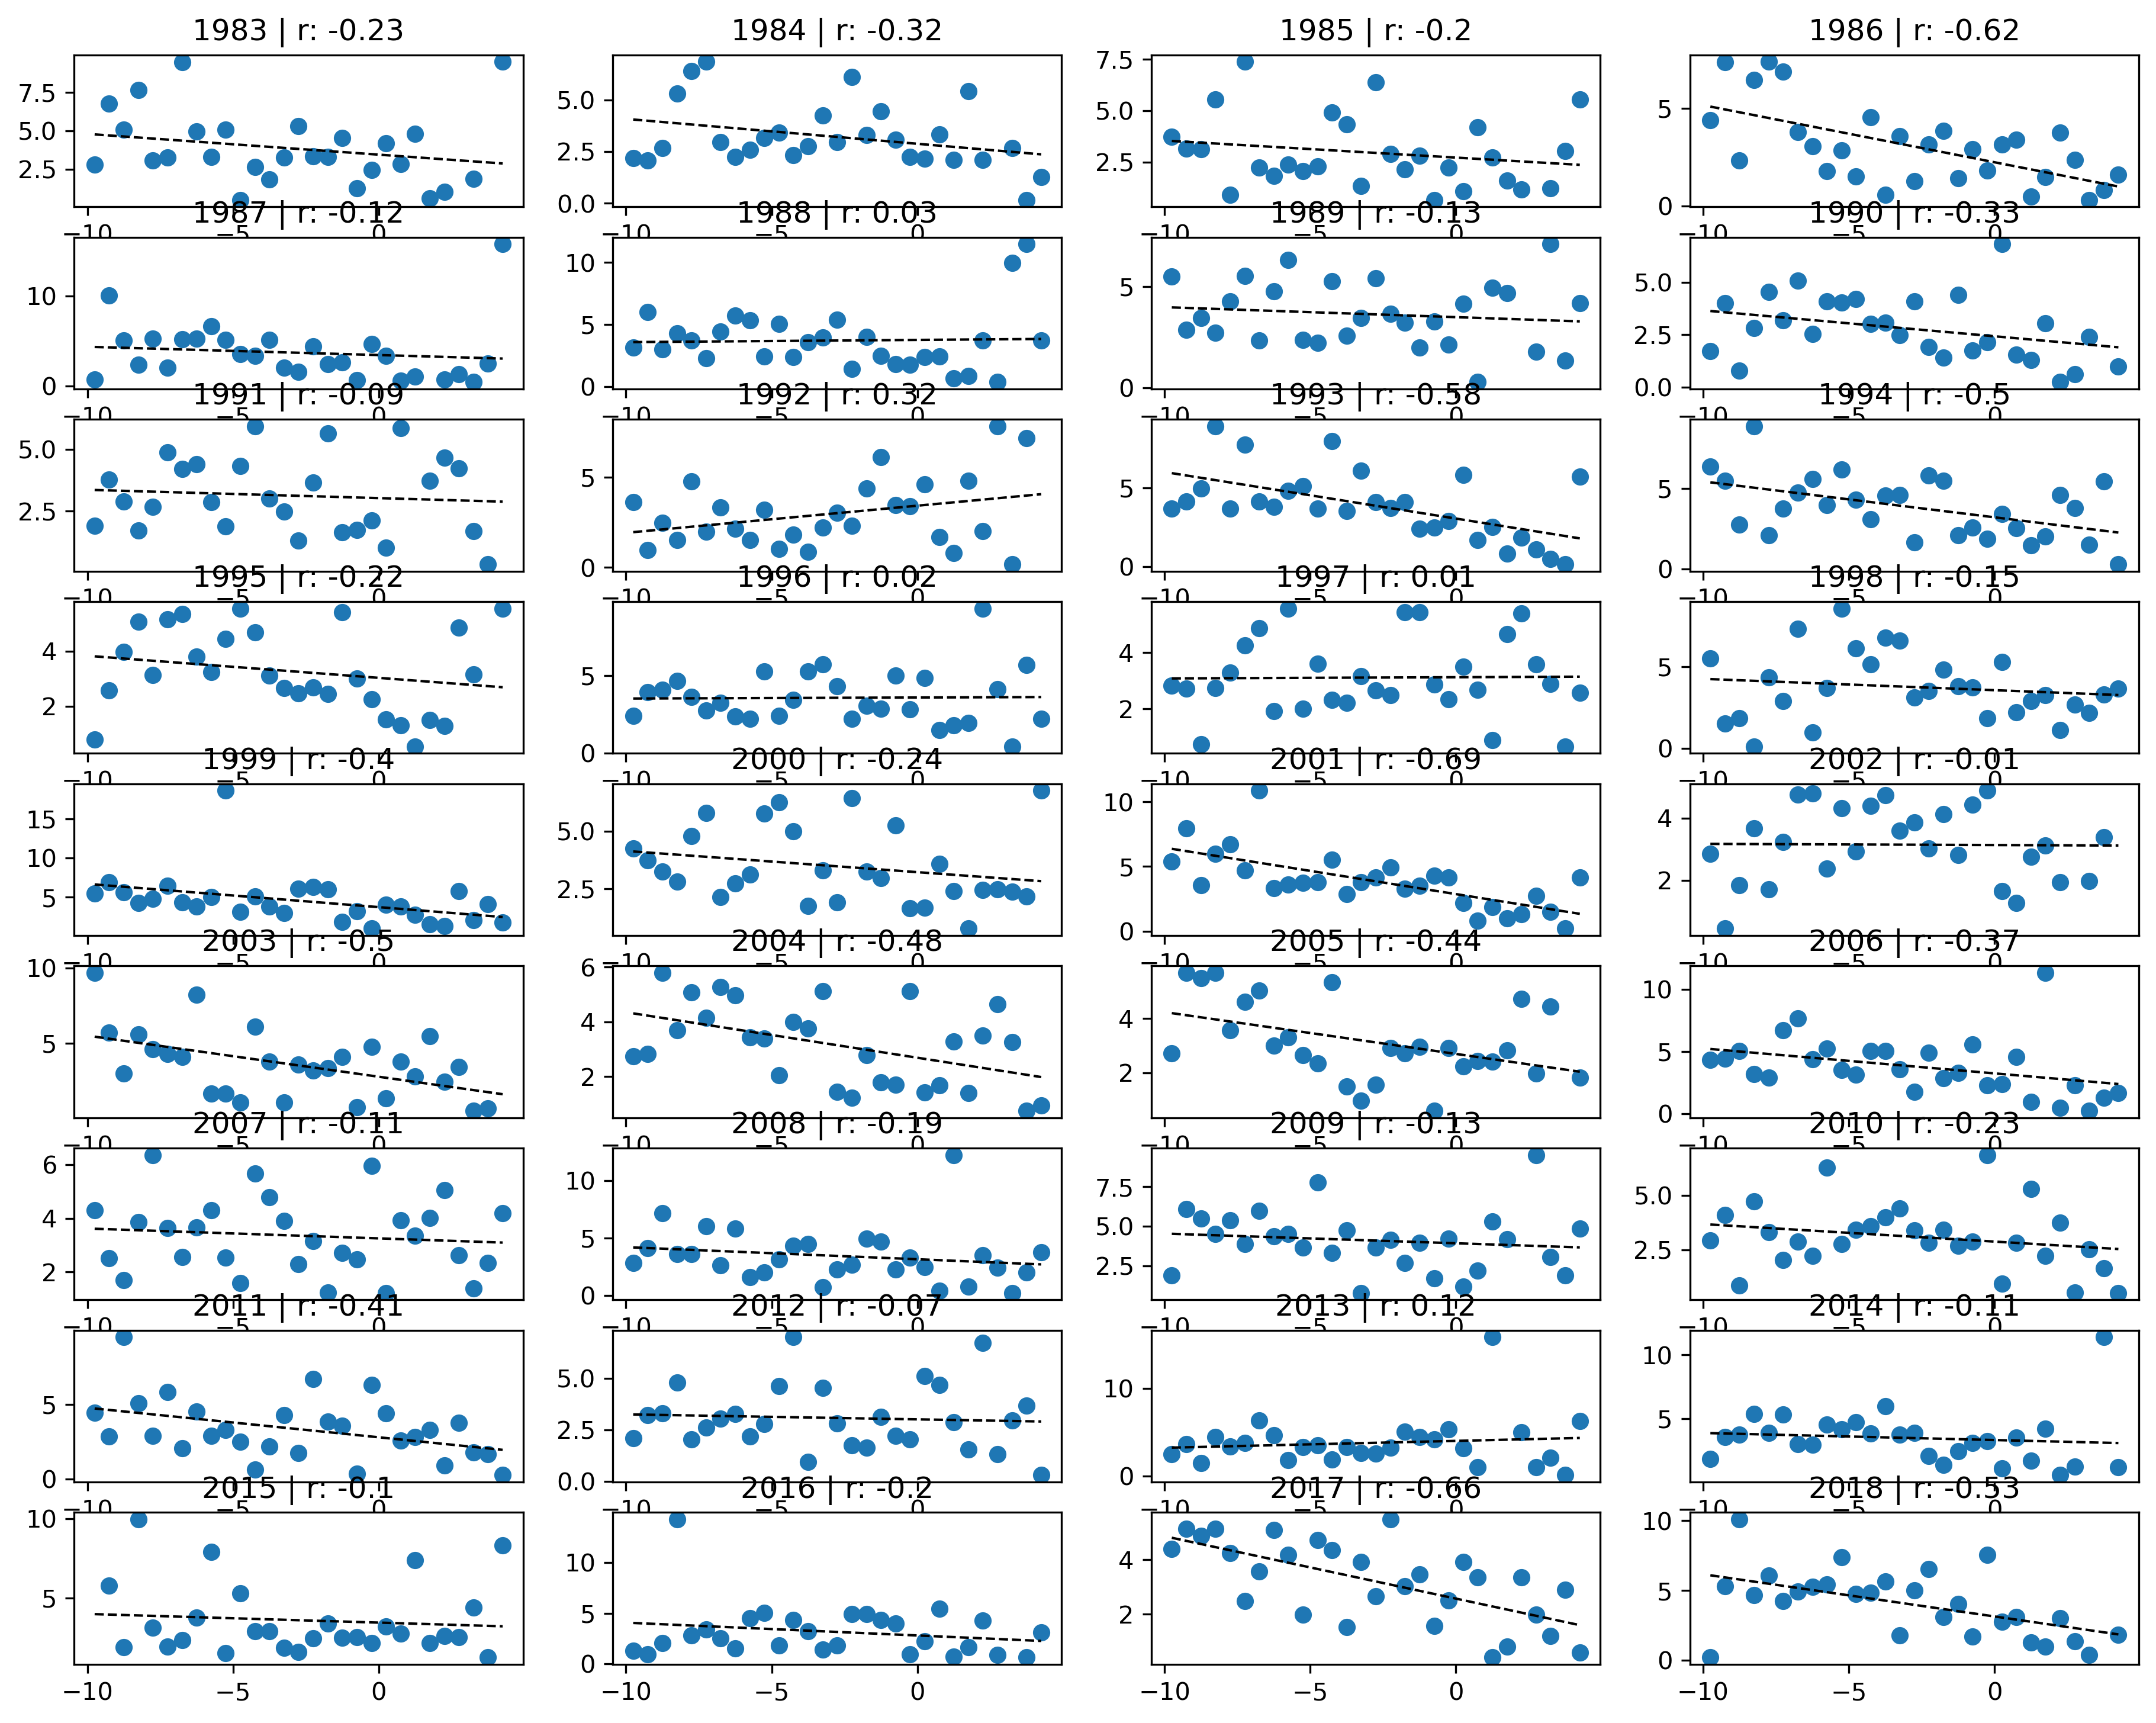

In [75]:
f = plt.figure(figsize=(15,12), dpi=300)
v850_stats = {'corr': [], 'pval' : [], 'slope' : []}
for ids,y in enumerate(range(1983,2019)):
    cadic = perc_1d_binning(cav850[cav850['time.year']==y], v850ca[v850ca['time.year']==y], xbins=np.arange(-10,5,0.5))
    isval = np.isfinite(cadic['data'])
    b, a, r_value, p_value, std_err = linregress(np.array(cadic['xbins'])[isval],np.array(cadic['data'])[isval])

    ax = f.add_subplot(9,4,ids+1)
    ax.scatter(cadic['xbins'], cadic['data'])
    ax.plot(cadic['xbins'], a+cadic['xbins']*b, color='k', linestyle='dashed', linewidth=1)
    plt.title(str(y)+' | r: '+str(np.round(r_value,2)))
    v850_stats['corr'].append(r_value)
    v850_stats['pval'].append(p_value)
    v850_stats['slope'].append(b)

In [76]:
years = np.unique(cau200['time.year'])

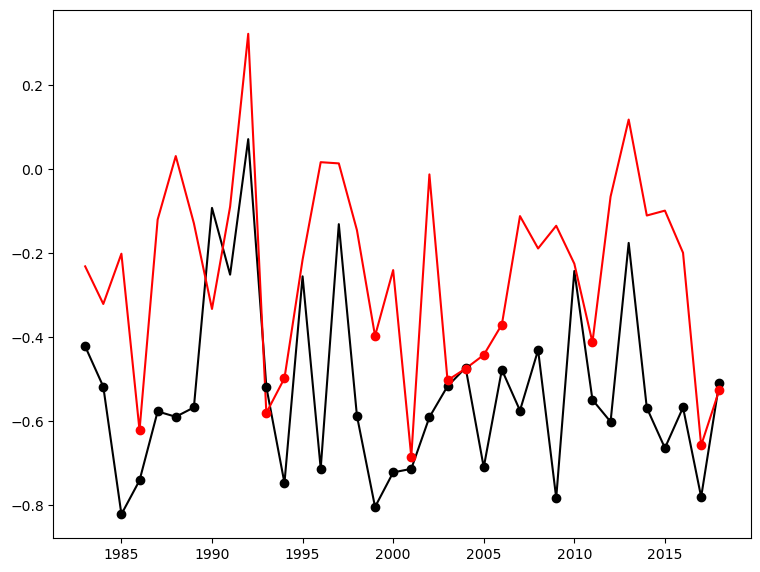

In [86]:
f = plt.figure(figsize=(9,7), dpi=100)
ax = f.add_subplot(111)

valpos2 = np.array(u200_stats['pval'])<0.05
xval2  = (years[2::])[valpos2]
yval2 = np.array(u200_stats['corr'])[valpos2]

valpos8 = np.array(v850_stats['pval'])<0.05
xval8  = (years[2::])[valpos8]
yval8 = np.array(v850_stats['corr'])[valpos8]

plt.plot(years[2::],u200_stats['corr'], linestyle='-', color='k')
plt.plot(years[2::],v850_stats['corr'], linestyle='-', color='r')
                                     
plt.plot(xval2,yval2, marker='o', linestyle='', color='k')
plt.plot(xval8,yval8, marker='o', linestyle='', color='r')
                                     
                    

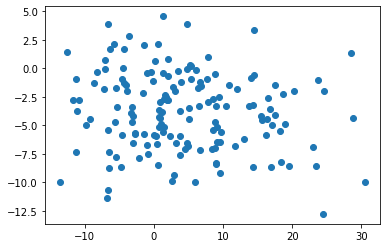

In [71]:
udoy = u200orig['u'].rolling(time=3, min_periods=1, center=True).mean(dim='time') # time=3
cdoy = gridsat['tir'].rolling(time=3, min_periods=1, center=True).mean(dim='time')

In [ ]:
f = plt.figure(figsize=(15,12), dpi=300)
u200_stats = {'corr': [], 'pval' : [], 'slope' : []}

for ids,y in enumerate(range(1983,2019)):
    udoy = u200orig['u'].rolling(time=3, min_periods=1, center=True).mean(dim='time') # time=3
    cdoy = gridsat['tir'].rolling(time=3, min_periods=1, center=True).mean(dim='time')
    cadic = perc_1d_binning(cau200[cau200['time.year']==y], u200ca[u200ca['time.year']==y], xbins=np.arange(-15,15,1))
    isval = np.isfinite(cadic['data'])
    b, a, r_value, p_value, std_err = linregress(np.array(cadic['xbins'])[isval],np.array(cadic['data'])[isval])

    ax = f.add_subplot(9,4,ids+1)
    ax.scatter(cadic['xbins'], cadic['data'])
    ax.plot(cadic['xbins'], a+cadic['xbins']*b, color='k', linestyle='dashed', linewidth=1)
    plt.title(str(y)+' | r: '+str(np.round(r_value,2)))
    u200_stats['corr'].append(r_value)
    u200_stats['pval'].append(p_value)
    u200_stats['slope'].append(b)

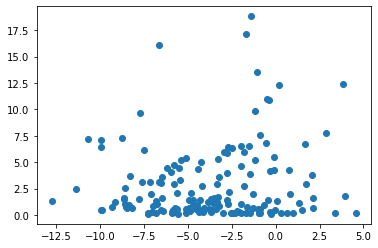

In [72]:
plt.scatter(v850ca[v850ca['time.year']==y], cav850[cav850['time.year']==y])